# OpenVino Model Implementation

In [55]:
INPUT_WIDTH = 640
INPUT_HEIGHT = 640
SCORE_THRESHOLD = 0.2
# initialize minimum probability to filter weak detections along with
CONFIDENCE_THRESHOLD = 0.4
# the threshold when applying non-maximum suppression
NMS_THRESHOLD = 0.4
# define the minimum safe distance (in pixels) that two people can be
# from each other
MIN_DISTANCE = 700

In [56]:
import cv2
import numpy as np
from PIL import Image

In [57]:
def plot_boxes(img:np.ndarray, results:np.ndarray = None, color:tuple[int, int, int] = [0, 255, 0], boxes =None, line_thickness:int = None, defaulters:list[int] = None):
    if results is None and boxes is None:
        print("Error: results and centroids are both None, at least one of them should be not None")
        return
    bboxes= boxes or results[0]
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    for idx, box in enumerate(bboxes):
        if defaulters and idx in defaulters:
            color = [255, 255, 0]
        else:
            color = [0, 255, 0]
        c1, c2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)

In [58]:
def calc_centroids(results:np.ndarray):
    bboxes= results[0]
    centroids = []
    for box in bboxes:
        #box = xyxy[0:4]
        c = int((box[0] + box[2])/2), int((box[1] + box[3])/2)
        centroids.append(c)
    return centroids

In [59]:
def plot_centroids(img:np.ndarray, results:np.ndarray = None, color:tuple[int, int, int] = [0, 255, 0], centroids:list[tuple[int, int]] = None, line_thickness:int = None, defaulters:list[int] = None):
    if results is None and centroids is None:
        print("Error: results and centroids are both None, at least one of them should be not None")
        return
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    centroids = centroids or calc_centroids(results)
    for idx, centroid in enumerate(centroids):
        if defaulters and idx in defaulters:
            color = [255, 255, 0]
        else:
            color = [0, 255, 0]
        cv2.circle(img =img, center =centroid,radius=5, color=color, thickness=tl)

In [60]:
def show_violations(img:np.ndarray, instances:list[int], results:np.ndarray = None, centroids:list[tuple[int, int]]= None, line_thickness:int = None, color = [0, 255, 0]):
    if results is None and centroids is None:
        print("Error: results and centroids are both None, at least one of them should be not None")
        return
    elif centroids is None:
        centroids = calc_centroids(results)

    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  # line/font thickness
    for violation in instances:
        color = [255, 0, 0]
        i, j = violation
        cv2.line(img, centroids[i], centroids[j], color, tl)
    
    # draw the total number of social distancing violations on the output frame
    text = "Social Distancing Violations: {}".format(len(instances))
    cv2.putText(img, text, (10, img.shape[0] - 25),
		cv2.FONT_HERSHEY_SIMPLEX, 1.85, color, tl)

In [61]:
from scipy.spatial import distance as dist
def check_violations (results:dict, source_image:np.ndarray):
	if len(results) >= 2:
		# extract all centroids from the results and compute the
		# Euclidean distances between all pairs of the centroids
		centroids = calc_centroids(results)
		D = dist.cdist(centroids, centroids, metric="euclidean")

		violators = set()
		violations = set()
		# loop over the upper triangular of the distance matrix
		for i in range(0, D.shape[0]):
			for j in range(i + 1, D.shape[1]):
				# check to see if the distance between any two
				# centroid pairs is less than the configured number
				# of pixels
				if D[i, j] < MIN_DISTANCE:
					# update our violation set with the indexes of
					# the centroid pairs
					violators.add(i)
					violators.add(j)
					violations.add((i, j))
					print(f"violation: {D[i, j]}")
		
	# return the set of violations
	return violators, violations
		

In [62]:
def draw_results(results:dict, source_image:np.ndarray):
    """
    Helper function for drawing bounding boxes on image
    Parameters:
        image (np.ndarray): for drawing predictions of the format [x1, y1, x2, y2]
        source_image (np.ndarray): input image for drawing bounding boxes and centroids
    Returns:    
    """
    # boxes = results[0]
    # centroids = calc_centroids(results)
    # print(centroids)

    violators, violations = check_violations(results, source_image)
    
    # Plot the bounding boxes of the people detected
    plot_boxes(source_image, results, defaulters=violators)#, boxes=boxes)

    # Plot the centroids of the people detected
    plot_centroids(source_image, results, defaulters=violators)#, centroids=centroids)

    # Plot lines between centroids of people violating social distancing
    show_violations(source_image, instances= violations, results=results)#, centroids=centroids)
    

# CV2 Runtime

In [63]:
# Interfacing model outpurs with the rest of the code
def extract_boxes(preds:tuple, img:np.ndarray):
    confs, boxes = list(), list()

    image_height, image_width, _ = img.shape
    x_factor = image_width / INPUT_WIDTH
    y_factor = image_height / INPUT_HEIGHT

    rows = preds[0].shape[0]

    for i in range(rows):
        row = preds[0][i]
        conf = row[4]
        
        classes_score = row[4:]
        _,_,_, max_idx = cv2.minMaxLoc(classes_score)

        if (max_idx[0] == 0):

            if (classes_score[0] > .25):
                confs.append(conf)
                
                #extract boxes
                x, y, w, h = row[0:4] 
                left = int((x - 0.5 * w) * x_factor)
                top = int((y - 0.5 * h) * y_factor)
                width = int(w * x_factor)
                height = int(h * y_factor)
                box = np.array([left, top, left+width, top+height])
                boxes.append(box)
        else:
            continue
            
    r_confs, r_boxes = list(), list()

    indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.25, 0.45) 
    for i in indexes:
        r_confs.append(confs[i])
        r_boxes.append(boxes[i])
        #print('person', confs[i], boxes[i])
    return r_boxes, r_confs

In [64]:
# Load an image
img = cv2.imread("t.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [65]:
# Load a model
net = cv2.dnn.readNet('yolov8n.onnx')

In [66]:
 # Create a blob from image and pass it through the model
blob = cv2.dnn.blobFromImage(img, 1/255.0, (INPUT_WIDTH, INPUT_HEIGHT), swapRB=True, crop=False)
net.setInput(blob)
preds = net.forward()
preds = preds.transpose((0, 2, 1))

violation: 646.2236454974392


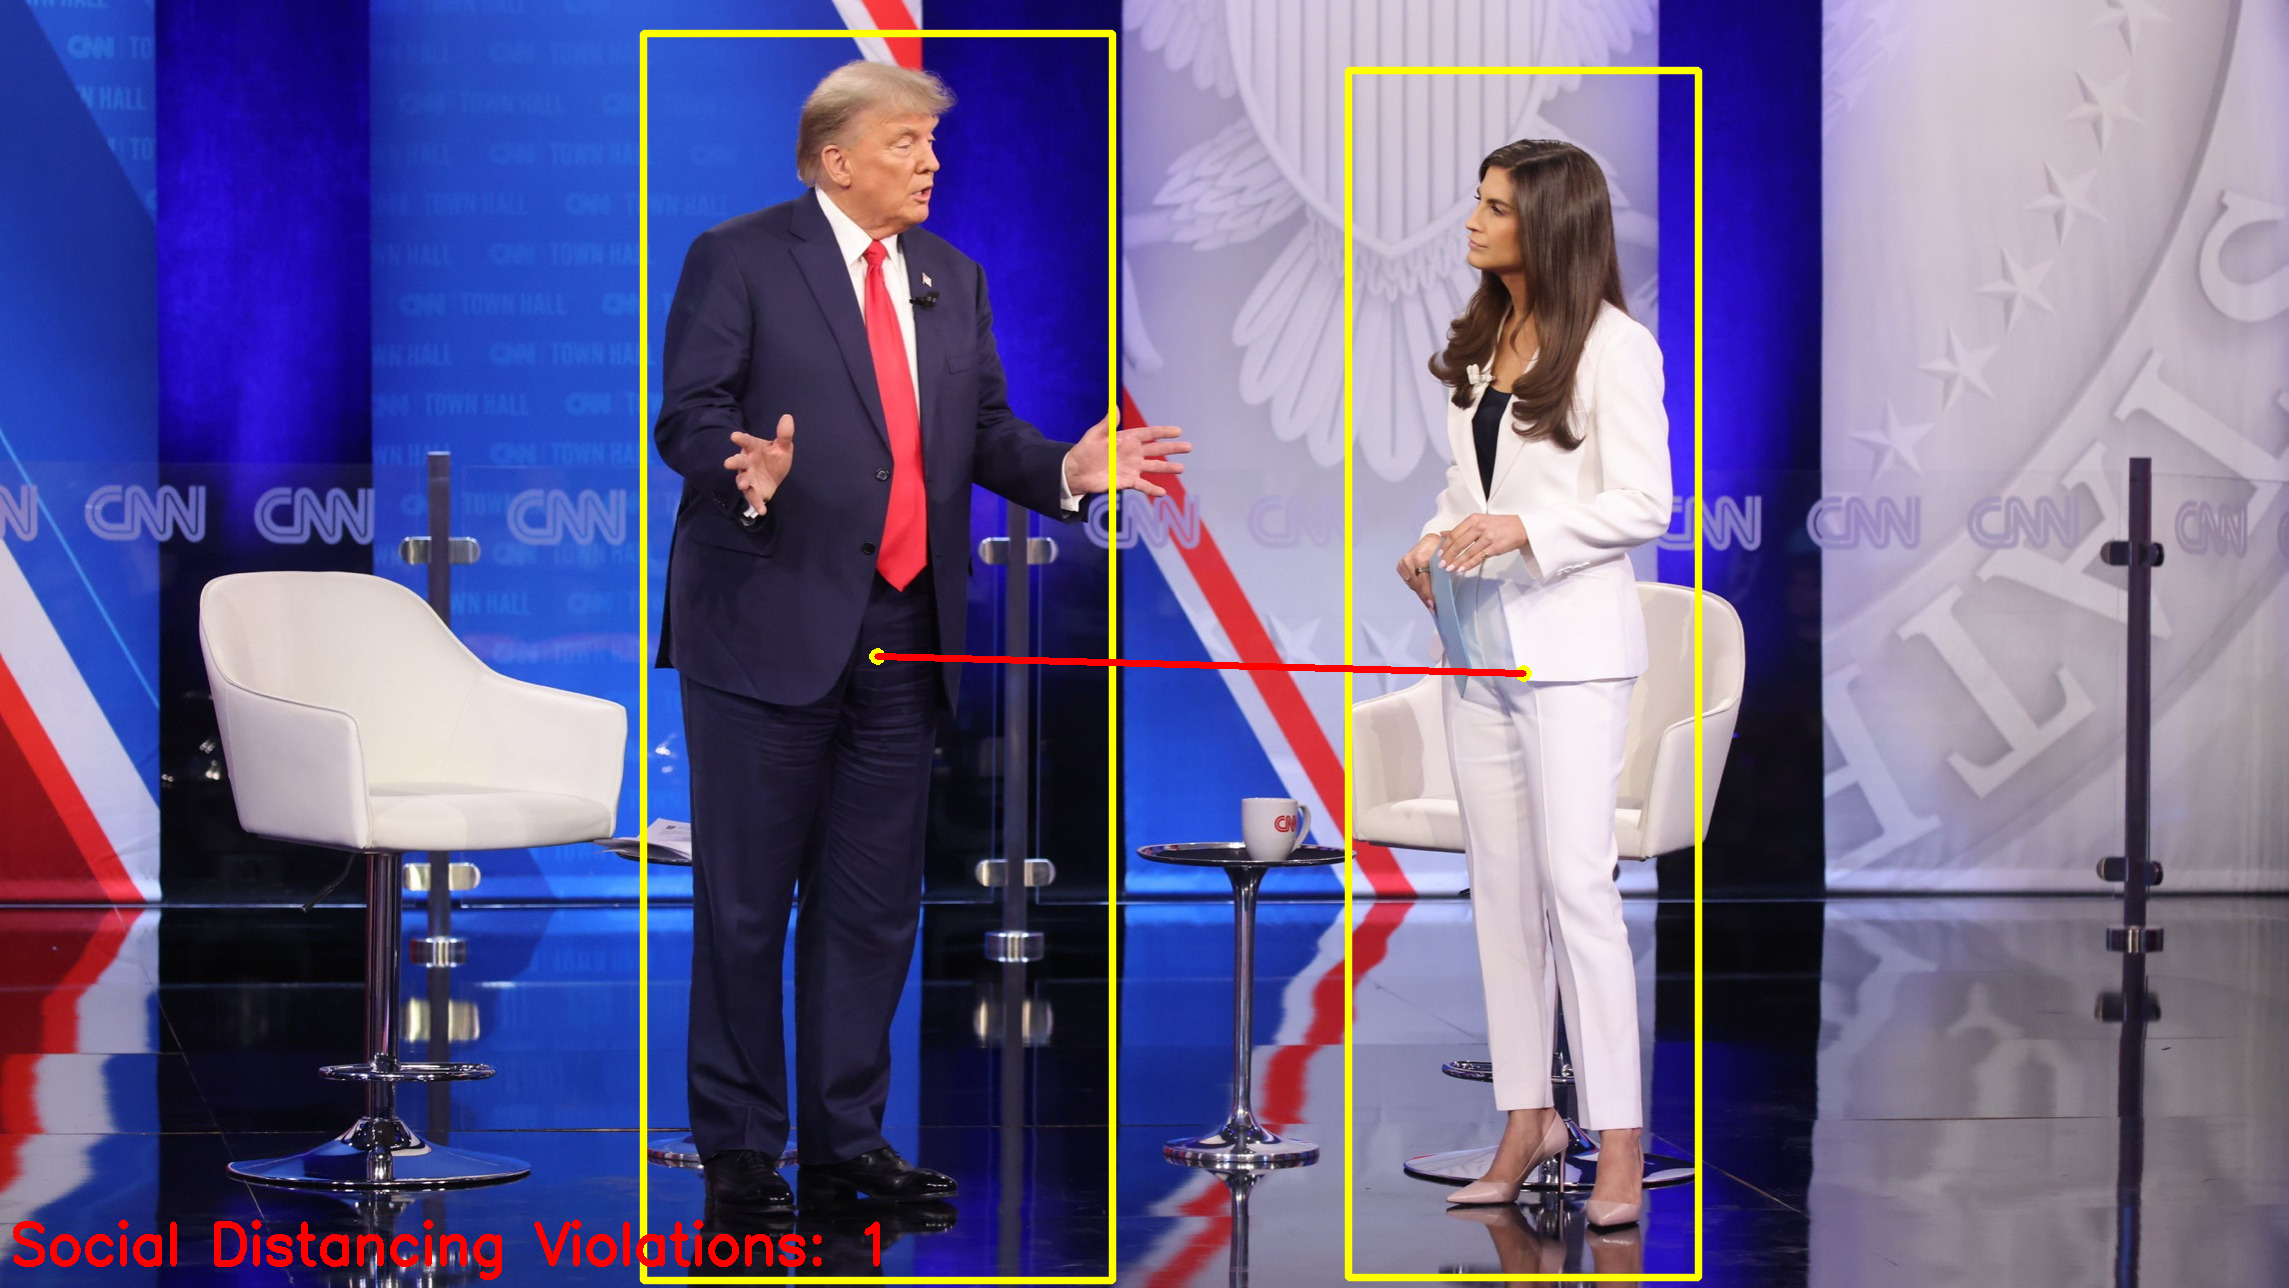

In [67]:
results = extract_boxes(preds, img)
draw_results(results, img)
Image.fromarray(img)